In [1]:
import torch
from transformers import CLIPModel, CLIPProcessor, CLIPVisionModel, CLIPVisionModelWithProjection
from PIL import Image
import torchvision
from torch.nn import DataParallel
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode
import warnings
import numpy as np

/home/users/mxy/miniconda3/envs/VLM_Poisoning/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


/home/users/mxy/miniconda3/envs/VLM_Poisoning/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
[2025-01-09 20:24:18,253] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
warnings.filterwarnings("ignore")
model_name = "openai/clip-vit-large-patch14"
clip_model = CLIPModel.from_pretrained(model_name).eval()
clip_vision_model = CLIPVisionModelWithProjection.from_pretrained("openai/clip-vit-base-patch32")
# clip_vision_model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained(model_name)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [3]:
input_res=clip_vision_model.vision_model.config.image_size

In [4]:
img_path = "../data/mini_MathVista_grid/target/bar.png"

with Image.open(img_path) as img:
    pil_image = img
    img_tensor = torchvision.transforms.PILToTensor()(img.convert('RGB'))

In [5]:
img_tensor.shape

torch.Size([3, 553, 699])

In [6]:
device = clip_vision_model.device

In [7]:
inputs = processor(images=img_tensor, return_tensors="pt")
# processed_img = torch.from_numpy(np.array(processor.image_processor.preprocess(img_tensor)["pixel_values"])).cuda()
inputs = inputs.to(device)

In [8]:
outputs = clip_vision_model(**inputs)

In [9]:
last_hidden_state_tensor = outputs.last_hidden_state

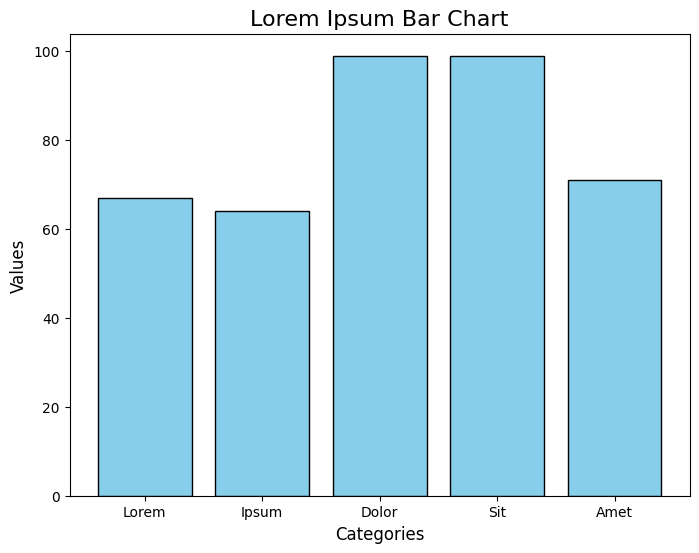

In [10]:
pil_image

In [11]:
pil_inputs = processor(images=pil_image, return_tensors="pt")
pil_outputs = clip_vision_model(**pil_inputs)
last_hidden_state_pil = pil_outputs.last_hidden_state

In [12]:
last_hidden_state_pil == last_hidden_state_tensor

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]])

In [2]:
from clip import MyClip

[2025-01-09 23:15:27,154] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [3]:
model = MyClip()

In [5]:
text_embeds = model.encode_text("hello, my name e jeff")

In [6]:
text_embeds.shape

torch.Size([1, 512])

# AEGE Work

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))  # Adjust as needed

from models.CLIP.clip import clip

In [2]:
import torchvision

In [3]:
from PIL import Image

In [4]:
import torch

In [5]:
import numpy as np

In [6]:
device = "cuda"

clip_rn_50,_ = clip.load('RN50', device=device)
clip_rn_101,_ = clip.load('RN101', device=device)
clip_vit_b_16,_ = clip.load('ViT-B/16', device=device)
clip_vit_b_32,_ = clip.load('ViT-B/32', device=device)
clip_vit_l_14,_ = clip.load('ViT-L/14', device=device)
models = [clip_rn_50, clip_rn_101, clip_vit_b_16, clip_vit_b_32, clip_vit_l_14]
# models = [clip_vit_b_32]
clip_preprocess = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(clip_vit_b_32.visual.input_resolution, interpolation=torchvision.transforms.InterpolationMode.BICUBIC, antialias=True),
        # torchvision.transforms.Lambda(lambda img: torch.clamp(img, 0.0, 255.0) / 255.0),
        torchvision.transforms.CenterCrop(clip_vit_b_32.visual.input_resolution),
        torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)), # CLIP imgs mean and std.
    ]
)
final_preprocess = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(clip_vit_b_32.visual.input_resolution, interpolation=torchvision.transforms.InterpolationMode.BICUBIC, antialias=True),
        # torchvision.transforms.Lambda(lambda img: torch.clamp(img, 0.0, 255.0) / 255.0),
        torchvision.transforms.CenterCrop(clip_vit_b_32.visual.input_resolution),
    ]
)


In [7]:
def to_tensor(pic):
    mode_to_nptype = {"I": np.int32, "I;16": np.int16, "F": np.float32}
    img = torch.from_numpy(np.array(pic, mode_to_nptype.get(pic.mode, np.uint8), copy=True))
    img = img.view(pic.size[1], pic.size[0], len(pic.getbands()))
    img = img.permute((2, 0, 1)).contiguous()
    return img.to(dtype=torch.get_default_dtype())

In [8]:
transform_fn = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(224, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.Lambda(lambda img: img.convert("RGB")),
            torchvision.transforms.Lambda(lambda img: to_tensor(img)),
            torchvision.transforms.Lambda(lambda img: torch.clamp(img, 0.0, 255.0) / 255.0),
        ]
    )
transform_fn_org = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(256, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
        torchvision.transforms.CenterCrop(256),
        torchvision.transforms.ToTensor(), # [0, 1]
        torchvision.transforms.Lambda(lambda img: (img * 2 - 1)),
        # torchvision.transforms.Lambda(lambda img: img.convert("RGB")),
        # torchvision.transforms.Lambda(lambda img: to_tensor(img)),
    ]
)

In [9]:
tgt_path = "../data/mini_MathVista_grid/target/bar.png"
adv_path = "../data/mini_MathVista_grid/target/abst.png"

with Image.open(tgt_path) as img:
    pil_image = img
    tgt_tensor = transform_fn(img.convert('RGB'))

with Image.open(adv_path) as img:
    pil_image = img
    adv_tensor = transform_fn(img.convert('RGB'))
    adv_tensor.requires_grad_(True)

In [10]:
# image_tgt = img_tensor.to(torch.float16).to(device)
image_tgt = tgt_tensor.to(device)
image_adv = adv_tensor.to(device)

In [11]:
image_tgt = image_tgt.unsqueeze(0)
image_adv = image_adv.unsqueeze(0)

In [12]:
with torch.no_grad():
    tgt_image_features_list=[]
    image_tgt = clip_preprocess(image_tgt)
    for clip_model in models:
        tgt_image_features = clip_model.encode_image(image_tgt)  # [bs, 512]
        tgt_image_features = tgt_image_features / tgt_image_features.norm(dim=1, keepdim=True)
        tgt_image_features_list.append(tgt_image_features)

In [13]:
adv_image_features_list=[]
image_adv = clip_preprocess(image_adv)
for clip_model in models:
    adv_image_features = clip_model.encode_image(image_adv)  # [bs, 512]
    adv_image_features = adv_image_features / adv_image_features.norm(dim=1, keepdim=True)
    adv_image_features_list.append(adv_image_features)

In [14]:
tau = 1.0  
costs = torch.ones(2, len(models))

In [16]:
model_losses=torch.zeros(len(models))
loss = torch.zeros(1).to(device)
crit_list = []
for model_i, (pred_i, target_i) in enumerate(zip(adv_image_features_list, tgt_image_features_list)):
    model_losses[model_i] = torch.mean(torch.sum(pred_i * target_i, dim=1))   


In [17]:


torch.sum(torch.exp(tau*(costs[0] / costs[1]+1e-16)), dim=1) / (len(models)*)

torch.Size([5])

In [28]:
tau = 1.0  
costs = torch.ones(2, len(models))

model_losses=torch.zeros(len(models))
loss = torch.zeros(1).to(device)
for model_i, (pred_i, target_i) in enumerate(zip(adv_image_features_list, tgt_image_features_list)):
    model_losses[model_i] = torch.mean(torch.sum(pred_i * target_i, dim=1))   

exp_cost_ratio = torch.exp(tau*(costs[1] / costs[0]+1e-16))
weights = torch.sum(exp_cost_ratio, dim=0) / (len(models)*exp_cost_ratio)
loss = torch.sum(weights * model_losses)

costs[1] = costs[0]
costs[0] = model_losses.clone().detach()


gradient = torch.autograd.grad(loss, adv_tensor)[0]
# gradient = torch.clamp(gradient, min=-0.0025, max=0.0025)  # 0.0025


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [27]:
gradient

tensor([[[-0.0025, -0.0025, -0.0025,  ..., -0.0025, -0.0019,  0.0025],
         [-0.0025, -0.0025, -0.0025,  ...,  0.0025,  0.0025,  0.0025],
         [-0.0025,  0.0025, -0.0025,  ...,  0.0025,  0.0025,  0.0025],
         ...,
         [-0.0025, -0.0025, -0.0025,  ...,  0.0025, -0.0025,  0.0025],
         [-0.0025,  0.0025, -0.0025,  ...,  0.0025,  0.0011,  0.0025],
         [ 0.0012,  0.0025, -0.0025,  ...,  0.0025,  0.0025,  0.0025]],

        [[-0.0025,  0.0025, -0.0025,  ..., -0.0025,  0.0025,  0.0025],
         [ 0.0025,  0.0025,  0.0025,  ..., -0.0025, -0.0025,  0.0025],
         [ 0.0025,  0.0025,  0.0025,  ..., -0.0025, -0.0025,  0.0025],
         ...,
         [-0.0025, -0.0025, -0.0025,  ..., -0.0025, -0.0025,  0.0025],
         [-0.0025, -0.0025, -0.0025,  ..., -0.0025, -0.0025,  0.0025],
         [ 0.0025, -0.0025, -0.0025,  ...,  0.0025,  0.0025,  0.0025]],

        [[-0.0025, -0.0025, -0.0025,  ...,  0.0025,  0.0025,  0.0025],
         [-0.0025,  0.0025, -0.0025,  ..., -0

In [56]:
tau = 1.0  
costs = torch.ones(2, len(models))
for iteration in range(iterations):#pseudo code
    model_losses=torch.zeros(len(models))
    loss = torch.zeros(1).to(device)
    crit_list = []
    adv_image_features_list = get_adv_image_features_list(adv_image)#pseudo code
    for model_i, (pred_i, target_i) in enumerate(zip(adv_image_features_list, tgt_image_features_list)):
        model_losses[model_i] = torch.mean(torch.sum(pred_i * target_i, dim=1))   

    exp_cost_ratio = torch.exp(tau*(costs[1] / costs[0]+1e-16))
    weights = torch.sum(exp_cost_ratio, dim=0) / (len(models)*exp_cost_ratio)
    loss = torch.sum(weights * model_losses)

    costs[1] = costs[0]
    costs[0] = model_losses.clone().detach()


    gradient = torch.autograd.grad(loss, adv_tensor)[0]
    gradient = torch.clamp(gradient, min=-0.0025, max=0.0025)  # 0.0025

    update_adv_image(adv_image) #pseudo code

In [58]:
gradient.size()

torch.Size([3, 224, 224])

In [47]:
image_adv

tensor([[[[1.3464, 1.2880, 1.3026,  ..., 1.3172, 1.3026, 1.3026],
          [1.3610, 1.3026, 1.3172,  ..., 1.3172, 1.3026, 1.3026],
          [1.3756, 1.3172, 1.3464,  ..., 1.3172, 1.3026, 1.3026],
          ...,
          [1.3026, 1.2880, 1.3026,  ..., 1.3318, 1.3318, 1.3318],
          [1.3318, 1.3026, 1.3026,  ..., 1.3318, 1.3318, 1.3318],
          [1.3756, 1.2880, 1.3026,  ..., 1.3318, 1.3318, 1.3318]],

         [[1.3095, 1.2645, 1.2795,  ..., 1.3095, 1.2945, 1.2945],
          [1.3245, 1.2795, 1.2945,  ..., 1.3095, 1.2945, 1.2945],
          [1.3395, 1.2945, 1.3095,  ..., 1.3095, 1.2945, 1.2945],
          ...,
          [1.3695, 1.3545, 1.3545,  ..., 1.3545, 1.3545, 1.3545],
          [1.3695, 1.3545, 1.3545,  ..., 1.3545, 1.3545, 1.3545],
          [1.3995, 1.3395, 1.3545,  ..., 1.3545, 1.3545, 1.3545]],

         [[1.1932, 1.0794, 1.0936,  ..., 1.0510, 1.0367, 1.0225],
          [1.1932, 1.0794, 1.1078,  ..., 1.0510, 1.0367, 1.0225],
          [1.1932, 1.0794, 1.1221,  ..., 1

In [64]:
# for i, feat in enumerate(tgt_image_features_list):
#     if torch.all(torch.isnan(feat)):
#         print("nothing here man", i)

In [ ]:
import torchvision
from PIL import Image
import torch
import numpy as np

import sys
import os
sys.path.append(os.path.abspath(".."))  # Adjust as needed

from models.CLIP.clip import clip

# models = [clip_vit_b_32]
clip_preprocess = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(clip_vit_b_32.visual.input_resolution, interpolation=torchvision.transforms.InterpolationMode.BICUBIC, antialias=True),
        # torchvision.transforms.Lambda(lambda img: torch.clamp(img, 0.0, 255.0) / 255.0),
        torchvision.transforms.CenterCrop(clip_vit_b_32.visual.input_resolution),
        torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)), # CLIP imgs mean and std.
    ]
)
final_preprocess = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(clip_vit_b_32.visual.input_resolution, interpolation=torchvision.transforms.InterpolationMode.BICUBIC, antialias=True),
        # torchvision.transforms.Lambda(lambda img: torch.clamp(img, 0.0, 255.0) / 255.0),
        torchvision.transforms.CenterCrop(clip_vit_b_32.visual.input_resolution),
    ]
)

class MyClipEnsemble():
    def __init__(self, tau=2):
        warnings.filterwarnings("ignore")
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        clip_rn_50,_ = clip.load('RN50', device=device)
        clip_rn_101,_ = clip.load('RN101', device=device)
        clip_vit_b_16,_ = clip.load('ViT-B/16', device=device)
        clip_vit_b_32,_ = clip.load('ViT-B/32', device=device)
        clip_vit_l_14,_ = clip.load('ViT-L/14', device=device)
        self.models = [clip_rn_50, clip_rn_101, clip_vit_b_16, clip_vit_b_32, clip_vit_l_14]

        self.clip_preprocess = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize(clip_vit_b_32.visual.input_resolution, interpolation=torchvision.transforms.InterpolationMode.BICUBIC, antialias=True),
                # torchvision.transforms.Lambda(lambda img: torch.clamp(img, 0.0, 255.0) / 255.0),
                torchvision.transforms.CenterCrop(clip_vit_b_32.visual.input_resolution),
                torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)), # CLIP imgs mean and std.
            ]
        )

        self.costs = torch.ones(2, len(self.models))
        self.tau = tau
        
    def encode_image(self, image, use_grad=True):
        image_features_list = []
        image_tgt = clip_preprocess(image)

        context = torch.enable_grad() if use_grad else torch.no_grad()
        with context:
            for clip_model in self.models:
                image_features = clip_model.encode_image(image_tgt)  # [bs, 512]
                image_features /= image_features.norm(dim=1, keepdim=True)
                image_features_list.append(image_features)

        return image_features_list
    
    def get_gradients(self, adv_image_features_list, tgt_image_features_list):
        model_losses=torch.zeros(len(self.models))
        loss = torch.zeros(1).to(self.device)
        for model_i, (pred_i, target_i) in enumerate(zip(adv_image_features_list, tgt_image_features_list)):
            model_losses[model_i] = torch.mean(torch.sum(pred_i * target_i, dim=1))   

        exp_cost_ratio = torch.exp(self.tau*(self.costs[1] / self.costs[0]+1e-16))
        weights = torch.sum(exp_cost_ratio, dim=0) / (len(self.models)*exp_cost_ratio)
        loss = torch.sum(weights * model_losses)

        self.costs[1] = self.costs[0]
        self.costs[0] = model_losses.clone().detach()


        gradient = torch.autograd.grad(loss, adv_tensor)[0]
        return gradient


nothing here man 0
nothing here man 1


In [ ]:
tau = 1.0  
costs = torch.ones(2, len(models))

model_losses=torch.zeros(len(models))
loss = torch.zeros(1).to(device)
for model_i, (pred_i, target_i) in enumerate(zip(adv_image_features_list, tgt_image_features_list)):
    model_losses[model_i] = torch.mean(torch.sum(pred_i * target_i, dim=1))   

exp_cost_ratio = torch.exp(tau*(costs[1] / costs[0]+1e-16))
weights = torch.sum(exp_cost_ratio, dim=0) / (len(models)*exp_cost_ratio)
loss = torch.sum(weights * model_losses)

costs[1] = costs[0]
costs[0] = model_losses.clone().detach()


gradient = torch.autograd.grad(loss, adv_tensor)[0]